# Flow Across Bump - Energetics
See a movie of model run at https://vimeo.com/200374154

In [1]:
# %load /Users/gunnar/Projects/python/standard_imports.py
%matplotlib inline
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import xarray as xr
import gsw

import warnings
warnings.filterwarnings('ignore')
mpl.rcParams.update({'font.size': 12})

## Read model data
Unfortunately the variables in `state.glob.nc` are written to different time steps than the diagnostic variables. We'll interpolate to the time vector of the diagnostic variables where needed.

In [2]:
DataDir = '/Volumes/svalbard/mitgcm/bump/B6/run/allmnc/'
# DataDir = '/Users/gunnar/Projects/model/bump_data/B6/allmnc/'

# read grid parameters, diagnostics output and state variables
b6 = xr.open_dataset(DataDir+'diag1.glob.nc')
b6s = xr.open_dataset(DataDir+'state.glob.nc')
grid = xr.open_dataset(DataDir+'grid.glob.nc')
# load additional diagnostics
b62 = xr.open_dataset(DataDir+'diag2.glob.nc')
# |PHIBOT  |  1 |       |SM      M1|m^2/s^2         |Bottom Pressure Pot.(p/rho) Anomaly
# |ETAN    |  1 |       |SM      M1|m               |Surface Height Anomaly

In [3]:
fileName = '/Users/gunnar/Projects/model/flow-across-bump/B6/input/Tref'
tref = np.fromfile(fileName)

## Easier plotting of fields

In [4]:
def CenterPlot(dy=50,ax=0):
    if ax==0:
        ax = plt.gca()
    ax.set(xlim=my+(-dy,dy))

In [5]:
def DistDepthPlot(field,dy=50):
    fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,5))
    h = ax.contourf(dist,grid.Z,field)
    CenterPlot(dy,ax=ax)
    plt.colorbar(h,ax=ax)

## Basic variables

In [6]:
# center of domain in km
my = grid.Y.values.mean()/1000
# distance in km
dist = grid.Y.values/1000

Center of domain is at {{np.round(my,1)}}km.

In [7]:
# Density
rho0 = 9.998000000000000e02 # from STDOUT, e.g.: grep -A 1 'rho' STDOUT.0000
gravity = 9.81
talpha = 2.0e-4
# convert reference temperature profile to matrix
trefm = np.tile(tref,(2000,1))
trefm = np.transpose(trefm)
# calculate densities
temp = np.squeeze(b6.THETA.values)
rho = rho0*(1-talpha*(temp))
rhopert = -rho0*talpha*(temp-trefm)
rhoref = -rho0*talpha*trefm

In [8]:
# Pressure
phi_hyd = b6.PHIHYD
phi_nh = b6s.phi_nh

# interpolate phi_nh to the time vector of phi_hyd
tmp = np.squeeze(phi_nh)
phi_nh2 = (tmp[1:,:,:].values + tmp[:-1,:,:].values) / 2
phi_hyd2 = np.squeeze(phi_hyd.values)

# R coordinate of cell center units: m
RC = np.tile(grid.RC,(2000,1))

# pressure perturbation
PP = phi_hyd2*rho0
q = phi_nh2*rho0

In [9]:
# Bathy Mask
BathyMask = np.squeeze(np.copy(grid.HFacC.values))
BathyMask[BathyMask<=0] = 0
BathyMaskNaN = BathyMask.copy()
BathyMaskNaN[BathyMask<=0] = np.nan

BathyMaskF = np.squeeze(np.copy(grid.HFacS.values))
BathyMaskF[BathyMaskF<=0] = 0
BathyMaskFNaN = BathyMaskF.copy()
BathyMaskFNaN[BathyMaskF<=0] = np.nan

In [10]:
# interpolate eta to time vector of the other variables
eta = np.squeeze((b6s.Eta.values[1:,:,:] + b6s.Eta.values[:-1,:,:]) / 2)
# Calculate height of water column (depth + eta)
tmp = np.tile(grid.Depth.values,(1,154))
tmp = np.rollaxis(tmp,0,2)
H = tmp+eta

In [11]:
phibot = b62.PHIBOT*rho0

In [12]:
hfacC = np.squeeze(grid.HFacC.values)

In [13]:
time = b6['T'].values/3600

In [14]:
dyF = np.squeeze(grid.dyF.values)

Horizontal eddy viscosity (`viscAh`)
$$\nu_H=10^{-4} \mathrm{m}^2/\mathrm{s}$$ 
Horizontal diffusivity of heat (and thereby mass with the LES, `diffKhT`):
$$\kappa_H=10^{-4} \mathrm{m}^2/\mathrm{s}$$ 
and vertical equivalents.

In [15]:
nuh = 1e-4
kappah = 1e-4
nuv = 1e-5
kappav = 1e-5

Bottom drag

In [16]:
Cd = 1e-3

## Barotropic/Baroclinic Velocities

The horizontal barotropic velocity $V$ is defined as
$$V = \frac{1}{H} \int_{-d}^{\eta}\, v\, dz = \frac{1}{H} \overline{v}$$

In [17]:
# barotropic horizontal velocity
# Include the bottom cell as a fraction and also sea surface height eta

# bring drF (cell height at faces) to matrix form
drF = np.tile(grid.drF.values.T,(2001,1))
drF = drF.T
# bring drFC (cell height at faces) to matrix form
drFC = np.tile(grid.drF.values.T,(2000,1))
drFC = drFC.T

# interpolate v from faces to center
VF = np.squeeze(b6.VVEL.values)
VC = (VF[:,:,1:]+VF[:,:,:-1]) / 2
V = (np.sum(VC*drFC*hfacC,axis=1) + eta*VC[:,0,:])/ H

In [18]:
# Baroclinic horizontal velocity
V2 = np.tile(V,(100,1,1))
V3 = np.rollaxis(V2,0,2)
v = VC-V3
v = v*BathyMaskNaN

In [19]:
# Bring barotropic V to size of baroclinic velocities v
Vm = np.tile(V,(100,1,1))
Vm = np.rollaxis(Vm,0,2)

In [20]:
# Barotropic vertical velocity
WF = np.squeeze(b6.WVEL)
# interpolate from upper faces to cell centers. there are no velocities defined at
# the bottom of the lowest cells. We'll simply repeat the velocities from the
# cells above to end up with the right dimensions here.
# np.dbstack() only works along the 3rd (last?) dimension, so we have to roll axes...
WFr = np.rollaxis(WF.values,1,3)
WF2 = np.dstack((WFr,WF[:,-1,:]))
WF2 = np.rollaxis(WF2,2,1)
WC = (WF2[:,1:,:]+WF2[:,:-1,:]) / 2
# calculate barotropic vertical velocity
W = (np.sum(WC*drFC*hfacC,axis=1) + eta*WC[:,0,:]) / H

In [21]:
# Baroclinic vertical velocity
# we need to bring W to the same shape as the velocity matrix WC
Wm = np.tile(W,(100,1,1))
Wm = np.rollaxis(Wm,0,2)

w = WC-Wm
w = w*BathyMaskNaN

## Energetics

### Kinetic Energy
The kinetic energy per unit volume, in units of J/m$^3$, is defined as

$$ E_k = \frac{1}{2} \rho_0 \mathbf{u} \cdot \mathbf{u}$$
$$ E_k = E_{hk0} + E'_k + E'_{hk0}$$

where (for our 2D case with east-west velocities being close to zero):

$$ E_{hk0} = \frac{1}{2} \rho_0 \mathbf{U_H} \cdot \mathbf{U_H} = \frac{1}{2} \rho_0 V^2$$
$$ E'_k = \frac{1}{2} \rho_0 (\mathbf{u'_H} \cdot \mathbf{u'_H} +w^2) = \frac{1}{2} \rho_0 (v^2 + w^2)$$
$$ E'_{hk0} = \frac{1}{2} \rho_0 \mathbf{U} \cdot \mathbf{u'} = \frac{1}{2} \rho_0 V v'$$

with the barotropic horizontal kinetic energy $E_{hk0}$, baroclinic kinetic energy $E'_k$ and the cross term $E'_{hk0}$. The depth-integrated kinetic energy is

$$\overline{E_k} = \overline{E_{hk0}} + \overline{E'_k} + \overline{E'_{hk0}}$$
$$\overline{E_k} = H E_{hk0} + \overline{E'_k} +0.$$

In [22]:
# full kinetic Energy
Ek = 1/2*rho0*(VC**2 + WC**2)
Ek = np.squeeze(Ek)*BathyMaskNaN

In [23]:
# barotropic horizontal kinetic energy
Ehk0 = 0.5*rho0*V**2
# bring to matrix form for plotting
Ehk0m = np.tile(Ehk0,(100,1,1))
Ehk0m = np.rollaxis(Ehk0m,0,2)

In [24]:
# baroclinic kinetic Energy
Ekp = 0.5*rho0*(v**2 + w**2)

In [25]:
# cross term
Ehk0p = 0.5*rho0*Vm*v

Plot $E_k$, $E_{hk0}$, $E'_k$ and $E'_{hk0}$ for one time step

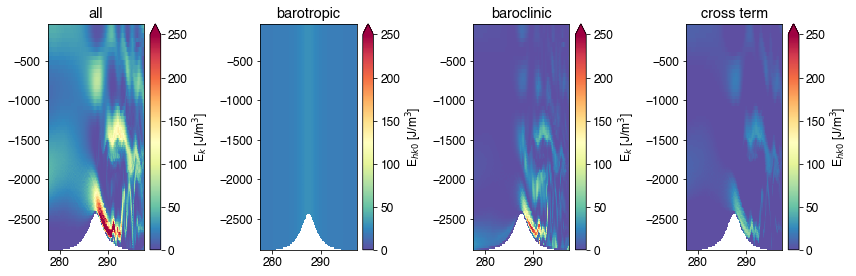

In [26]:
fig,ax = plt.subplots(ncols=4,figsize=(12,4))

TimeStep = -1
MaxC = 250

# all
EkMasked = np.ma.masked_where(np.squeeze(grid.HFacC)<=0, np.squeeze(Ek[TimeStep,:,:]))
h = ax[0].pcolormesh(dist,grid.Z,EkMasked,cmap='Spectral_r',vmin=0,vmax=MaxC)
CenterPlot(10,ax[0])
plt.colorbar(h,extend='max',label='E$_k$ [J/m$^3$]',ax=ax[0]);
ax[0].set_title('all')

# barotropic
Ehk0Masked = np.ma.masked_where(np.squeeze(grid.HFacC)<=0, np.squeeze(Ehk0m[TimeStep,:,:]))
h = ax[1].pcolormesh(dist,grid.Z,Ehk0Masked,cmap='Spectral_r',vmin=0,vmax=MaxC)
CenterPlot(10,ax[1])
plt.colorbar(h,extend='max',label='E$_{hk0}$ [J/m$^3$]',ax=ax[1]);
ax[1].set_title('barotropic')

# baroclinic
EkpMasked = np.ma.masked_where(np.squeeze(grid.HFacC)<=0, np.squeeze(Ekp[TimeStep,:,:]))
h = ax[2].pcolormesh(dist,grid.Z,EkpMasked,cmap='Spectral_r',vmin=0,vmax=MaxC)
CenterPlot(10,ax[2])
plt.colorbar(h,extend='max',label='E''$_k$ [J/m$^3$]',ax=ax[2]);
ax[2].set_title('baroclinic')

# cross-terms
Ehk0pMasked = np.ma.masked_where(np.squeeze(grid.HFacC)<=0, np.squeeze(Ehk0p[TimeStep,:,:]))
h = ax[3].pcolormesh(dist,grid.Z,Ehk0pMasked,cmap='Spectral_r',vmin=0,vmax=MaxC)
CenterPlot(10,ax[3])
plt.colorbar(h,extend='max',label='E$_{hk0}$ [J/m$^3$]',ax=ax[3]);
ax[3].set_title('cross term')

plt.tight_layout()

Depth-integrated kinetic energy. Cross term should come out to zero.

In [27]:
EkDepthIntegral = np.nansum(Ek*drFC*hfacC,axis=1) + Ek[:,0,:]*eta
EkpDepthIntegral = np.nansum(Ekp*drFC*hfacC,axis=1) + Ekp[:,0,:]*eta
Ehk0pDepthIntegral = np.nansum(Ehk0p*drFC*hfacC,axis=1) + Ehk0p[:,0,:]*eta
Ehk0DepthIntegral = np.nansum(Ehk0m*drFC*hfacC,axis=1) + Ehk0*eta

Plot all kinetic energy terms for last time step.

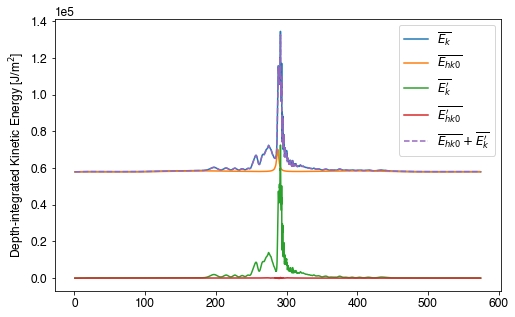

In [28]:
fig,ax = plt.subplots(figsize=(8,5))
ax.plot(dist,EkDepthIntegral[-1,:],label='$\overline{E_k}$')
ax.plot(dist,Ehk0DepthIntegral[-1,:],label='$\overline{E_{hk0}}$')
ax.plot(dist,EkpDepthIntegral[-1,:],label='$\overline{E^\prime_k}$')
ax.plot(dist,Ehk0pDepthIntegral[-1,:],label='$\overline{E^\prime_{hk0}}$')
ax.plot(dist,Ehk0DepthIntegral[-1,:]+EkpDepthIntegral[-1,:],
         linestyle='--',label='$\overline{E_{hk0}} + \overline{E^\prime_k}$')
ax.legend();
ax.set(ylabel='Depth-integrated Kinetic Energy [J/m$^2$]');

Temporal evolution of depth-integrated baroclinic and barotropic kinetic energy.

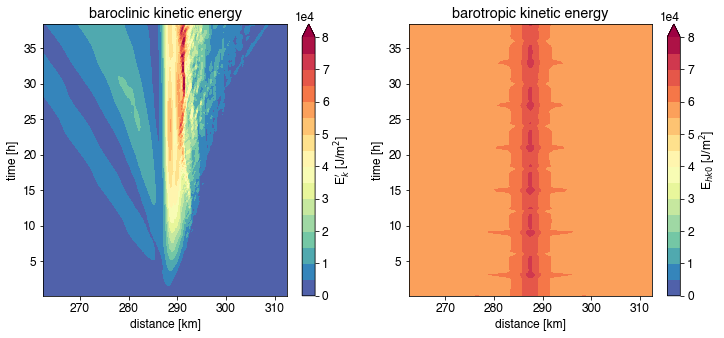

In [29]:
fig,ax = plt.subplots(ncols=2,figsize=(12,5))
h = ax[0].contourf(dist,time,EkpDepthIntegral,np.linspace(0,8e4,17),cmap='Spectral_r',extend='max')
plt.colorbar(h,ax=ax[0],label='E$^\prime_k$ [J/m$^2$]')
CenterPlot(25,ax[0])
ax[0].set(xlabel='distance [km]',ylabel='time [h]',title='baroclinic kinetic energy')

h = ax[1].contourf(dist,time,Ehk0DepthIntegral,np.linspace(0,8e4,17),cmap='Spectral_r',extend='max')
plt.colorbar(h,ax=ax[1],label='E$_{hk0}$ [J/m$^2$]')
CenterPlot(25,ax[1])
ax[1].set(xlabel='distance [km]',ylabel='time [h]',title='barotropic kinetic energy');

### Potential Energy
#### Perturbation Potential Energy
Perturbation potential energy per unit area [J/m$^2$]
$$ \overline{E_{p0}} = \int_0^\eta \rho_0\, g\, z\, dz = 1/2\, \rho_0\, g\, \eta^2$$

In [30]:
Ep0 = 0.5*rho0*gravity*eta**2

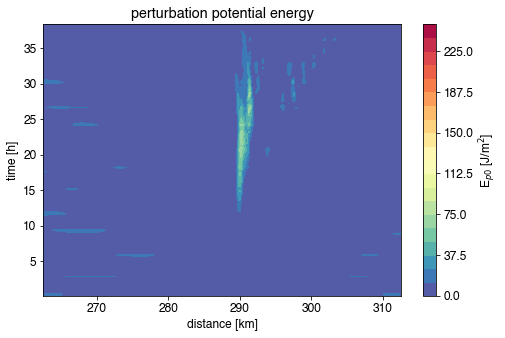

In [31]:
fig,ax = plt.subplots(figsize=(8,5))
h = ax.contourf(dist,time,Ep0,np.linspace(0,2.5e2,21),cmap='Spectral_r')
plt.colorbar(h,extend='max',label='E$_{p0}$ [J/m$^2$]')
CenterPlot(25,ax=ax)
ax.set(xlabel='distance [km]',ylabel='time [h]',title='perturbation potential energy');

#### Available Potential Energy

Available potential energy per unit volume [J/m$^3$]
$$  E_p' = \int_{z-\zeta}^z g [\rho(z)-\rho_r(z')]dz' $$

The APE can be approximated with the Linear Available Potential Energy Density, $APE$ and $APE_{lin}$ are the same when the stratification of the fluid is constant.
$$ APE_{lin} = \frac{g^2 \rho'^2}{2 \rho_0 N^2} $$
with
$$ N^2 = \frac{g}{\rho_0} \frac{\partial \rho'}{\partial z}$$

In this case, we can use the linearized APE but would have to create a look-up table for the vertical distance of a given density to the reference density profile if stratification was non-linear.

In [32]:
Epp = gravity**2*(rhopert*BathyMaskNaN)**2/(2*rho0*1e-6)

TODO: Calculate APE following Lamb as in the lee wave paper

In [33]:
# def CalculateAPE(ty, ctd):
#     ffsg = np.array(ctd['sg4filt'])
#     ffz = np.array(ctd['z'])
#     Ea = np.array([])
#     for sg4 in ty.gsw_sigma4.values.T:
#     # sg4 = ty.gsw_sigma4.values[:,11]
#         zz = ty.z.values
#         H = np.array([])
#         drho = np.array([])
#         for r, z in zip(sg4, zz):
#             if ~np.isnan(r) and r>InterfaceSG4:
#                 if r>np.max(sg4):
#                     H = np.append(H, 5300-z)
#                     i2 = gv.near(ffz, 5300)
#                     iz = gv.near(ffz, z) # index of far field depth == towyo depth
#                     drho = np.append(drho, r-(np.nanmean(ffsg[iz:i2])))
#                 elif r>InterfaceSG4:
#                     i2 = gv.near(ffsg, r) # index of far field sg==towyo sigma
#                     iz = gv.near(ffz, z) # index of far field depth == towyo depth
#                     H = np.append(H, ffz[i2]-z)
#                     drho = np.append(drho, r-(np.nanmean(ffsg[iz:i2])))

#         Eatmp = gsw.grav(np.nanmean(ty.lat)) * np.nanmean(H*drho)
#         Ea = np.append(Ea, Eatmp)
#     ty['APE'] = (['x'], Ea)
#     return ty

Depth-integrated APE

In [34]:
EppDepthIntegral = np.nansum(Epp*drFC*hfacC,axis=1)

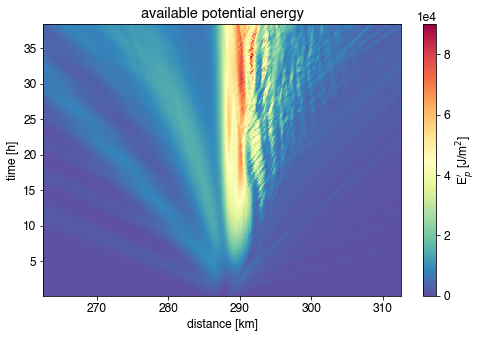

In [35]:
fig,ax = plt.subplots(figsize=(8,5))
h = ax.pcolormesh(dist,time,EppDepthIntegral,cmap='Spectral_r')
CenterPlot(25)
plt.colorbar(h,ax=ax,label='E$^\prime_p$ [J/m$^2$]')
ax.set(xlabel='distance [km]',ylabel='time [h]',title='available potential energy');

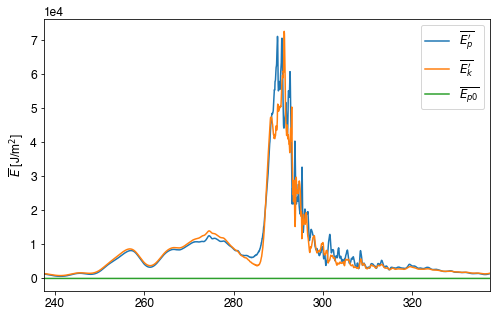

In [36]:
ti = -1
fig,ax = plt.subplots(figsize=(8,5))
ax.plot(dist,EppDepthIntegral[ti,:],label='$\overline{E^\prime_p}$')
# ax.plot(grid.Y/1e3,Ekind[ti,:],label='KE')
ax.plot(dist,EkpDepthIntegral[ti,:],label='$\overline{E^\prime_k}$')
ax.plot(dist,Ep0[ti,:],label='$\overline{E_{p0}}$')
ax.legend()
ax.set(ylabel='$\overline{E}$ [J/m$^2$]')
CenterPlot()

In [37]:
E = EppDepthIntegral+Ep0+EkDepthIntegral

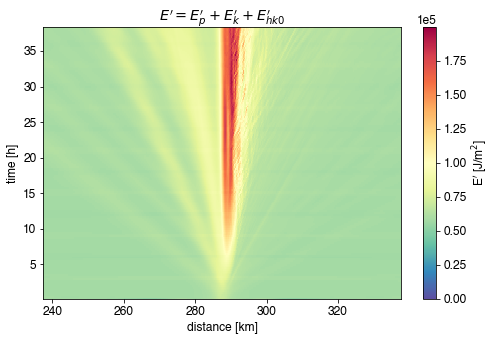

In [38]:
fig,ax = plt.subplots(figsize=(8,5))
h = ax.pcolormesh(dist,time,E,cmap='Spectral_r',vmin=0)
plt.colorbar(h,label='E$^\prime$ [J/m$^2$]')
CenterPlot(50,ax=ax)
ax.set(xlabel='distance [km]',ylabel='time [h]',title='$E^\prime = E^\prime_p + E^\prime_k + E^\prime_{hk0}$');

## Buoyancy Flux and BT-BC Conversion

The buoyancy flux is defined as
$$F_B = \rho' g w$$
and the depth-integrated buoyancy flux within a fixed water column as
$$\overline{F_B} = \int_{-d}^{\eta} \rho' g w\, dz $$
with density perturbation $\rho'$, gravity $g$ and vertical velocity $w$.

The depth-integrated barotropic to baroclinic conversion term is defined as
$$F_{Conv} = \overline{\rho' g W}$$
with the barotropic vertical velocity $W$. Units of the depth-integrated conversion are W/m$^2$.

In [39]:
BuoyancyFlux = gravity*rhopert*WC

In [40]:
BTBCConversion = gravity*rhopert*Wm*BathyMaskNaN

Depth integrals of buoyancy flux and BT-BC conversion

In [41]:
# calculate depth at the grid faces from drF and HFacS
# DepthC = np.sum(drFC*np.squeeze(grid.HFacC.values),axis=0)
BuoyancyFluxDepthIntegral = np.nansum(BuoyancyFlux*drFC*hfacC,axis=1)
BTBCConversionDepthIntegral = np.nansum(BTBCConversion*drFC*hfacC,axis=1)

The BT-BC conversion also has the non-hydrostatic part
$$\overline{\frac{\partial q}{\partial z} W}$$

In [42]:
qz = np.gradient(q,grid.Z,axis=1)

In [43]:
nhBTBCConversion = qz*Wm*BathyMaskNaN

Depth-integrated non-hydrostatic conversion

In [44]:
nhBTBCConversionDepthIntegral = np.nansum(nhBTBCConversion*drFC*hfacC,axis=1)

Total conversion:

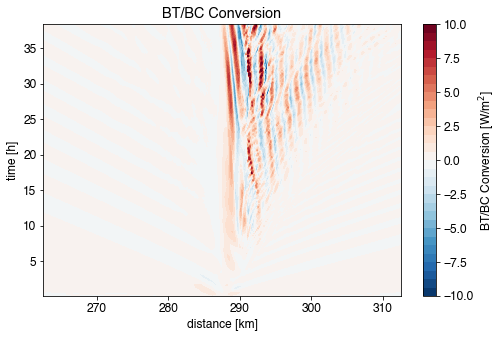

In [45]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,5))
h = ax.contourf(dist,time,BTBCConversionDepthIntegral-nhBTBCConversionDepthIntegral,
            np.linspace(-10,10,33),cmap='RdBu_r')
plt.colorbar(h,ax=ax,label='BT/BC Conversion [W/m$^2$]')
CenterPlot(25,ax=ax)
ax.set(xlabel='distance [km]',ylabel='time [h]',title='BT/BC Conversion');

## Turbulent Dissipation
Integrate turbulent dissipation from Jody's parametrization with depth.

In [46]:
eps = np.squeeze(b6.KLeps.values)*BathyMaskNaN

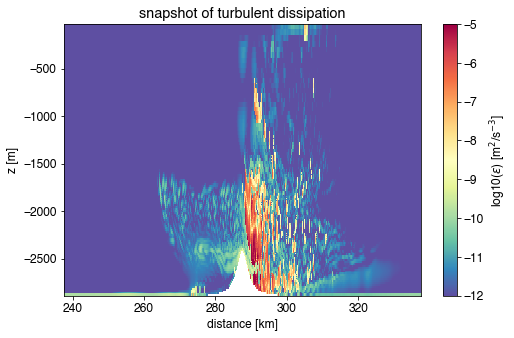

In [47]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,5))
h = ax.pcolormesh(grid.Y/1e3,grid.Z,np.ma.masked_where(np.squeeze(grid.HFacC)<1,np.log10(eps[150,:,:])),vmin=-12,vmax=-5,cmap='Spectral_r')
plt.colorbar(h,ax=ax,label=r'log10($\epsilon$) [m$^2$/s$^{-3}$]')
CenterPlot()
ax.set(xlabel='distance [km]',ylabel='z [m]',title='snapshot of turbulent dissipation');

In [48]:
epsDepthIntegral = np.nansum(rho0*hfacC*eps*drFC,axis=1)

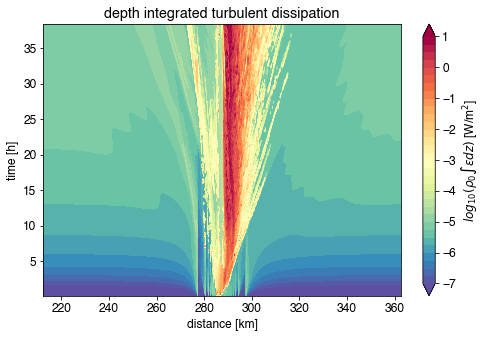

In [49]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,5))
h = ax.contourf(dist,time,np.log10(epsDepthIntegral),np.linspace(-7,1,33),cmap='Spectral_r',extend='both')
CenterPlot(75,ax)
plt.colorbar(h,ax=ax,label=r'$log_{10}(\rho_0 \int \epsilon dz)$ [W/m$^2$]');
ax.set(ylabel='time [h]',xlabel='distance [km]',title='depth integrated turbulent dissipation');

## Baroclinic energy equation
Terms of the baroclinic energy equations. Different to Kang (2011) we'll evaluate the energy equation not only depth-integrated, but also integrated across the ridge in the horizontal. Thus, the equation will be expressed in units of W/m. We are still integrating over the whole water column, thus volume integrals over flux divergences that are converted to surface integrals over the fluxes using the divergence theorem will be expressed as the difference between the flux at coordinates $y_1$ and $y_2$.

In [50]:
AdvectiveTimeScale = 0.2*time[-1]*3600/1e3

In [51]:
# integrate over this distance in km left and right of the ridge
dy = 25
yi = np.squeeze(np.where( (dist>my-dy) & (dist<my+dy) ))

The advective lateral scale for the whole model run is about {{round(AdvectiveTimeScale)}}km. Well start out with integrating {{round(dy)}}km on each side of the ridge.

### Unsteadiness
$$ \frac{\partial}{\partial t} \left( \iint E^\prime_k\, dy\, dz + \iint E^\prime_p\, dy\, dz \right) $$

In [52]:
EkpVI = np.sum(EkpDepthIntegral[:,yi]*dyF[yi],axis=1) # VI stands for volume integral
EppVI = np.sum(EppDepthIntegral[:,yi]*dyF[yi],axis=1) # VI stands for volume integral
# time derivative
dEkpVIdt = np.gradient(EkpVI,(time*3600))
dEppVIdt = np.gradient(EppVI,(time*3600))
BC_Unsteadiness = dEkpVIdt+dEppVIdt

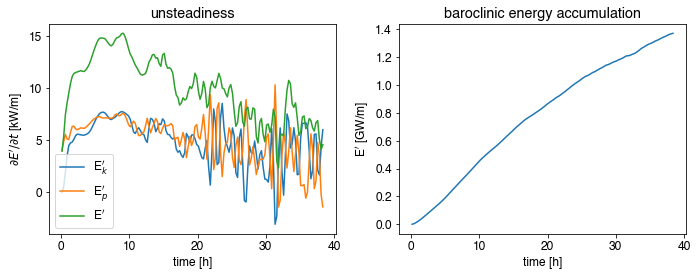

In [53]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(10,4))
# fig,ax = gvf.newfig()
ax[0].plot(time,dEkpVIdt/1e3,label='E$^\prime_k$')
ax[0].plot(time,dEppVIdt/1e3,label='E$^\prime_p$')
ax[0].plot(time,BC_Unsteadiness/1e3,label='E$^\prime$')
ax[0].set(xlabel='time [h]',ylabel='$\partial E^\prime / \partial t$ [kW/m]',title='unsteadiness')
ax[0].legend()
ax[1].plot(time,(EkpVI+EppVI)/1e9)
ax[1].set(ylabel='E$^\prime$ [GW/m]',xlabel='time [h]',title='baroclinic energy accumulation')
plt.tight_layout()

In [54]:
PotentialBarotropicKineticenergyAccumulation = 1/2*rho0*0.2**2*3000*time[-1]*3600/1e9

After initial spinup, baroclinic energy increases at a rate of about 10 kW/m within the control volume. A total of more than 1 GW/m accumulates in the baroclinic flow- and pressure field over the time of the model run. For comparison, the total energy that could be extracted over this time from barotropic flow of 0.2 m/s over 3000 m depth would be close to {{round(PotentialBarotropicKineticenergyAccumulation)}} GW.

### BT/BC Conversion
Hydrostatic and non-hydrostatic terms:
$$\iint \rho^\prime g W\, dz\, dy - \iint \frac{\partial q}{\partial z} W\, dz\, dy + \int A_{h0}\, dy$$
Energy is converted to baroclinic motion / potential energy when the whole term is positive. $A_{h0}$
denotes the contribution of unclosed advection terms:
$$A_{h0} = \rho_0 H V A_y$$
with
$$A_y =\frac{1}{H} \nabla_H \left( \int v^\prime v \,dz \right)$$
<!-- such that $$\int A_{h0} dy =\Delta_y \left( \rho_0 V \int  v^\prime v\, dz \right)$$
where $\Delta$ denotes the the difference between left and right, essentially this is the volume integral over the flux divergence transformed to the area integral over the flux itself using the divergence theorem. -->

In [55]:
BTBCConversionVI = np.sum(BTBCConversionDepthIntegral[:,yi]*dyF[yi],axis=1)
nhBTBCConversionVI = np.sum(nhBTBCConversionDepthIntegral[:,yi]*dyF[yi],axis=1)

tmp = np.nansum(v*VC*hfacC*drFC,axis=1)
Ay = np.gradient(tmp,grid.Y,axis=1)
Ah0 = rho0*V*Ay
Ah0YIntegral = np.sum(Ah0[:,yi]*dyF[yi],axis=1)

BC_Conversion = BTBCConversionVI-nhBTBCConversionVI+Ah0YIntegral

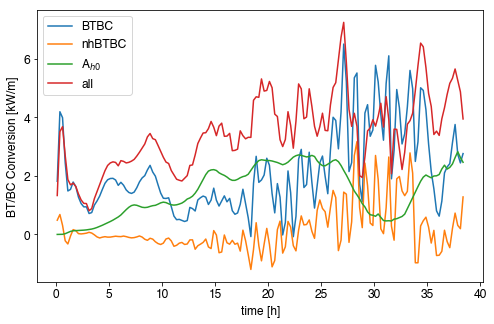

In [56]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,5))
ax.plot(time,BTBCConversionVI/1e3,label='BTBC')
ax.plot(time,nhBTBCConversionVI/1e3,label='nhBTBC')
ax.plot(time,(Ah0YIntegral)/1e3,label=r'A$_{h0}$')
ax.plot(time,(BC_Conversion)/1e3,label='all')
ax.set(ylabel='BT/BC Conversion [kW/m]',xlabel='time [h]');
ax.legend();

### Flux-Advection

$$\int \nabla_H \left(\int v E^\prime_k dz + \int v E^\prime_{hk0} dz + \int v E^\prime_p dz  \right) dy$$

$$ = \Delta_y \left( \int v E^\prime_k dz \right) + \Delta_y \left( \int v E^\prime_{hk0}dz \right) + \Delta_y \left( \int v E^\prime_p dz \right) $$
where $\Delta$ denotes the the difference between left and right, essentially this is the volume integral over the flux divergence transformed to the area integral over the flux itself using the divergence theorem.

In [57]:
EkpFluxDepthIntegral = np.nansum(VC*Ekp*drFC*hfacC,axis=1)
EppFluxDepthIntegral = np.nansum(VC*Epp*drFC*hfacC,axis=1)
Ehk0pFluxDepthIntegral = np.nansum(VC*Ehk0p*drFC*hfacC,axis=1)
EkpFluxDepthIntegralDelta = EkpFluxDepthIntegral[:,yi[0]]-EkpFluxDepthIntegral[:,yi[-1]]
EppFluxDepthIntegralDelta = EppFluxDepthIntegral[:,yi[0]]-EppFluxDepthIntegral[:,yi[-1]]
Ehk0pFluxDepthIntegralDelta = Ehk0pFluxDepthIntegral[:,yi[0]]-Ehk0pFluxDepthIntegral[:,yi[-1]]
BC_EnergyFluxDivergence = EkpFluxDepthIntegralDelta+Ehk0pFluxDepthIntegralDelta+Ehk0pFluxDepthIntegralDelta

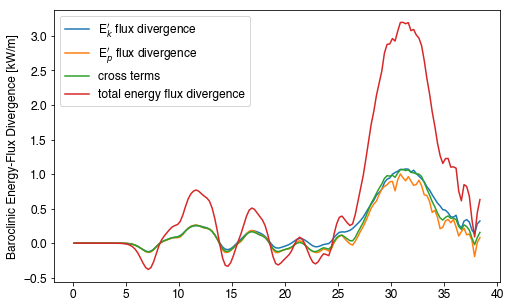

In [58]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,5))
ax.plot(time,EkpFluxDepthIntegralDelta/1e3,label='E$^\prime_k$ flux divergence')
ax.plot(time,EppFluxDepthIntegralDelta/1e3,label='E$^\prime_p$ flux divergence')
ax.plot(time,Ehk0pFluxDepthIntegralDelta/1e3,label='cross terms')
ax.plot(time,(EkpFluxDepthIntegralDelta+Ehk0pFluxDepthIntegralDelta+Ehk0pFluxDepthIntegralDelta)/1e3,label='total energy flux divergence')
ax.set(ylabel='Baroclinic Energy-Flux Divergence [kW/m]')
ax.legend();

### Flux-Pressure

$$ \Delta_y \left(\int v^\prime p^\prime \,dz \right) + \Delta_y \left( \int v^\prime q\, dz \right)$$

In [59]:
BCPressureFluxDepthIntegral = np.nansum(v*hfacC*PP*drFC,axis=1)
nhBCPressureFluxDepthIntegral = np.nansum(v*hfacC*q*drFC,axis=1)

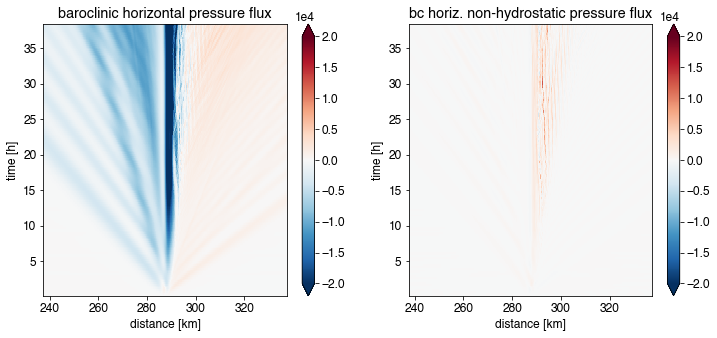

In [60]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(12,5))
h = ax[0].pcolormesh(dist,time,BCPressureFluxDepthIntegral,vmin=-2e4,vmax=2e4,cmap='RdBu_r')
plt.colorbar(h,ax=ax[0],extend='both')
ax[0].set(xlabel='distance [km]',ylabel='time [h]',title='baroclinic horizontal pressure flux')
CenterPlot(50,ax=ax[0])
h = ax[1].pcolormesh(dist,time,nhBCPressureFluxDepthIntegral,vmin=-2e4,vmax=2e4,cmap='RdBu_r')
plt.colorbar(h,ax=ax[1],extend='both')
ax[1].set(xlabel='distance [km]',ylabel='time [h]',title='bc horiz. non-hydrostatic pressure flux')
CenterPlot(50,ax=ax[1])

In [61]:
BCPressureFluxDepthIntegralDelta = BCPressureFluxDepthIntegral[:,yi[0]]-BCPressureFluxDepthIntegral[:,yi[-1]]
nhBCPressureFluxDepthIntegralDelta = nhBCPressureFluxDepthIntegral[:,yi[0]]-nhBCPressureFluxDepthIntegral[:,yi[-1]]

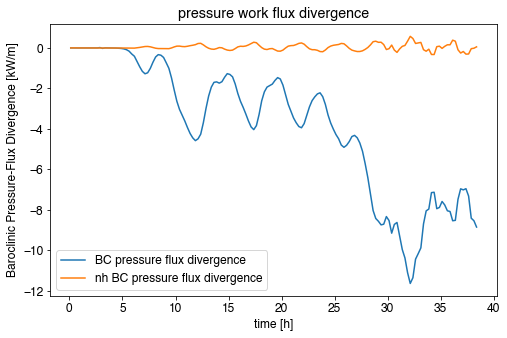

In [62]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,5))
ax.plot(time,BCPressureFluxDepthIntegralDelta/1e3,label='BC pressure flux divergence')
ax.plot(time,nhBCPressureFluxDepthIntegralDelta/1e3,label='nh BC pressure flux divergence')
ax.set(ylabel='Baroclinic Pressure-Flux Divergence [kW/m]',xlabel='time [h]',title='pressure work flux divergence')
ax.legend();

Vertical pressure work flux - this doesn't show up when integrting over the whole water column, but let's see if there is upward energy flux.

In [63]:
wppp = w*hfacC*PP
BCVerticalPressureFluxDepthIntegral = np.nansum(w*hfacC*PP*drFC,axis=1)
nhBCVerticalPressureFluxDepthIntegral = np.nansum(w*hfacC*q*drFC,axis=1)

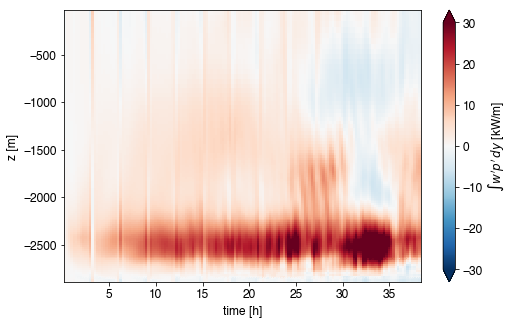

In [64]:
wpppHorizontalIntegral = np.nansum(wppp[:,:,100:-100]*dyF[100:-100],axis=2)
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,5))
h = ax.pcolormesh(time,grid.Z,wpppHorizontalIntegral.T/1e3,vmin=-30,vmax=30,cmap='RdBu_r')
plt.colorbar(h,ax=ax,label=r'$\int w^\prime p^\prime \, dy$ [kW/m]',extend='both')
ax.set(xlabel='time [h]',ylabel='z [m]');

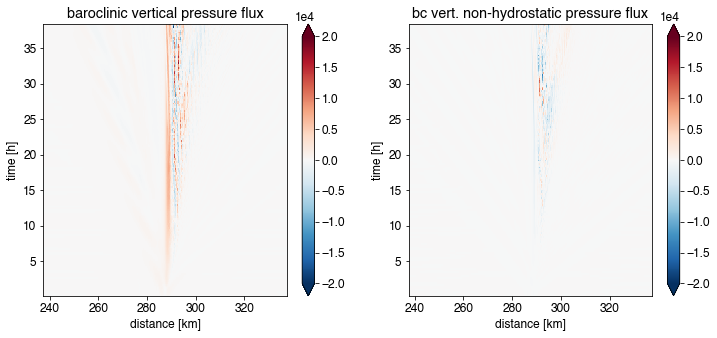

In [65]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(12,5))
h = ax[0].pcolormesh(dist,time,BCVerticalPressureFluxDepthIntegral,vmin=-2e4,vmax=2e4,cmap='RdBu_r')
plt.colorbar(h,ax=ax[0],extend='both')
ax[0].set(xlabel='distance [km]',ylabel='time [h]',title='baroclinic vertical pressure flux')
CenterPlot(50,ax=ax[0])
h = ax[1].pcolormesh(dist,time,nhBCVerticalPressureFluxDepthIntegral,vmin=-2e4,vmax=2e4,cmap='RdBu_r')
plt.colorbar(h,ax=ax[1],extend='both')
ax[1].set(xlabel='distance [km]',ylabel='time [h]',title='bc vert. non-hydrostatic pressure flux')
CenterPlot(50,ax=ax[1])

### Dissipation

$$\iint \rho_0 \epsilon \,dz\, dy $$

In [66]:
epsVI = np.nansum(epsDepthIntegral[:,yi]*dyF[yi],axis=1)

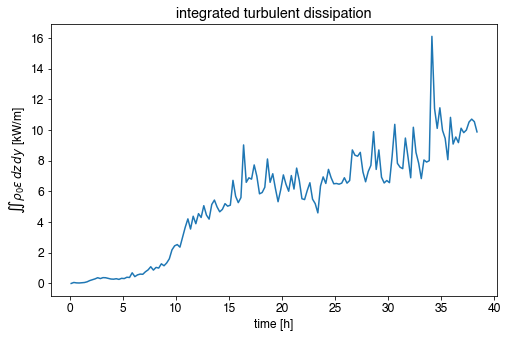

In [67]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,5))
ax.plot(time,epsVI/1e3)
ax.set(ylabel=r'$\iint \rho_0 \epsilon \,dz\, dy$ [kW/m]',xlabel='time [h]',title='integrated turbulent dissipation');

The above is the dissipation of turbulent kinetic energy as given by Jody's parametrization. How would the turbulent dissipation as calculated in Kang (2010) look like?. Here the horizontal baroclinic dissipation rate is given by
$$\epsilon^\prime_h = \rho_0 \nu_H \left( \nabla_H v^\prime \cdot \nabla_H v^\prime \right) + \rho_0 \nu_V \left( \frac{\partial v^\prime}{\partial z} \cdot \frac{\partial v^\prime}{\partial z} \right)$$
where the horizontal gradient operator reduces to $\partial/\partial y$ in the 2D case. The vertical baroclinic dissipation rate
$$ \epsilon^\prime_V = \rho_0 \nu_H \left( \frac{\partial w^\prime}{\partial y} \cdot  \frac{\partial w^\prime}{\partial y} \right) + \rho_0 \nu_V \left( \frac{\partial w^\prime}{\partial z} \cdot  \frac{\partial w^\prime}{\partial z}  \right) $$

In [68]:
dvdz = np.gradient(v,np.abs(grid.Z),axis=1)
dvdy = np.gradient(v,grid.Y,axis=2)
dwdz = np.gradient(w,np.abs(grid.Z),axis=1)
dwdy = np.gradient(w,grid.Y,axis=2)

In [69]:
epsph = rho0*nuh*dvdy*dvdy + rho0*nuv*dvdz*dvdz
epspv = rho0*nuh*dwdy*dwdy + rho0*nuv*dwdz*dwdz

Plot snapshots of $\epsilon^\prime_h$ and $\epsilon^\prime_v$

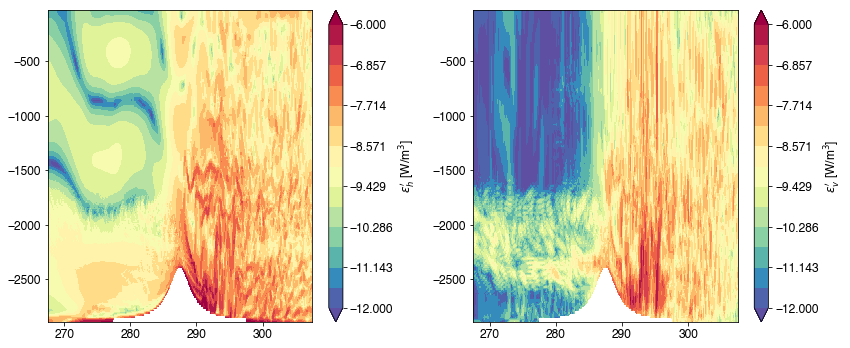

In [70]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(12,5))
h = ax[0].contourf(dist,grid.Z,np.log10(epsph[-1,:,:]),np.linspace(-12,-6,15),cmap='Spectral_r',extend='both')
plt.colorbar(h,ax=ax[0],label=r'$\epsilon^\prime_h$ [W/m$^3$]')
CenterPlot(20,ax=ax[0])
h = ax[1].contourf(dist,grid.Z,np.log10(epspv[-1,:,:]),np.linspace(-12,-6,15),cmap='Spectral_r',extend='both')
CenterPlot(20,ax=ax[1])
plt.colorbar(h,ax=ax[1],label=r'$\epsilon^\prime_v$ [W/m$^3$]');
plt.tight_layout()

Volume integral - note that here density is already included in the epsilon calculation, hence above figures show turbulent dissipation three orders of magnitude higher than when expressed in W/kg.

In [71]:
eps2DepthIntegral = np.nansum((epsph+epspv)*drFC*hfacC,axis=1)

In [72]:
eps2VI = np.nansum(eps2DepthIntegral[:,yi]*dyF[yi],axis=1)

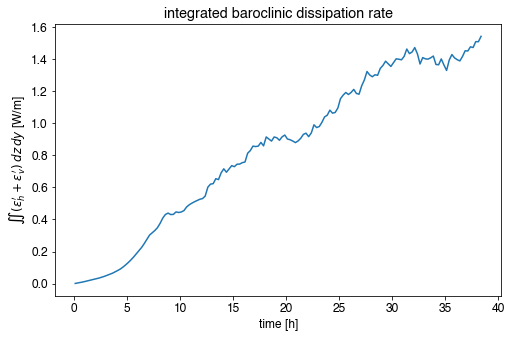

In [73]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,5))
ax.plot(time,eps2VI)
ax.set(ylabel=r'$\iint (\epsilon^\prime_h + \epsilon^\prime_v) \,dz\, dy$ [W/m]',xlabel='time [h]',title='integrated baroclinic dissipation rate');

### Bottom Drag
We are using a quadratic bottom drag that shows up in the energy equation as
$$ D^\prime = \rho_0 C_{d,B} \lvert v(-d) \rvert \left( v^\prime(-d) v(-d) + w^{\prime 2}(-d)   \right) $$ where $-d$ denotes values in the bottom cells. I'm not sure why this is $v^\prime v$ and not $v^{\prime2}$ in Kang (2010). Bottom Drag always extracts energy

In [74]:
# find bottom cells
tmp = hfacC
BottomCells = np.zeros_like(grid.Y.values,dtype='int')
for i, column in enumerate(tmp.T):
    indices = np.argwhere(column>0)
#     out.append(indices[-1])
    BottomCells[i] = indices[-1]

In [75]:
BottomDrag = np.zeros_like(eta)*np.nan
for i, t in enumerate(time):
    for j, d in enumerate(BottomCells):
        BottomDrag[i,j] = rho0*Cd*abs(VC[i,d,j])*(v[i,d,j]**2+w[i,d,j]**2)

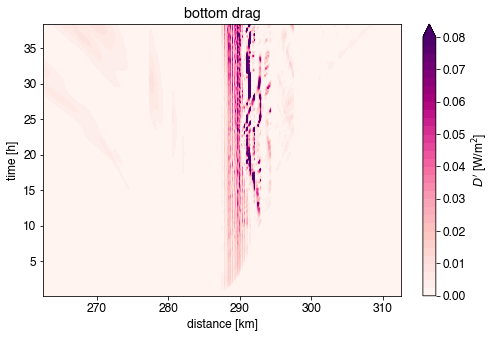

In [76]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,5))
h = ax.contourf(dist,time,BottomDrag,np.linspace(0,0.08,33),cmap='RdPu',extend='max')
plt.colorbar(h,ax=ax,label='$D^\prime$ [W/m$^2$]')
CenterPlot(25)
ax.set(xlabel='distance [km]',ylabel='time [h]',title='bottom drag');

In [77]:
BottomDragVI = np.nansum(BottomDrag*dyF,axis=1)

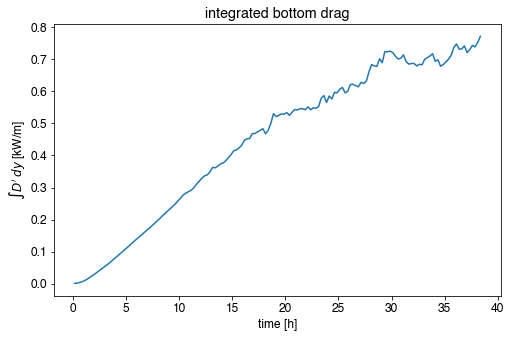

In [78]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,5))
ax.plot(time,BottomDragVI/1e3)
ax.set(ylabel=r'$\int D^\prime \, dy$ [kW/m]',xlabel='time [h]',title='integrated bottom drag');

### All Terms
of the baroclinic energy equation, see [Kang (2010)](http://rci.rutgers.edu/~dk556/Kang_PhD_2010.pdf#page=102) p. 81. 
...except for diffusion of Energy fluxes.

In [79]:
BC_EnergyEquationLeft = (BC_Unsteadiness +
                        BCPressureFluxDepthIntegralDelta +
                        nhBCPressureFluxDepthIntegralDelta +
                        BC_EnergyFluxDivergence)
BC_EnergyEquationRight = BC_Conversion - epsVI-BottomDragVI

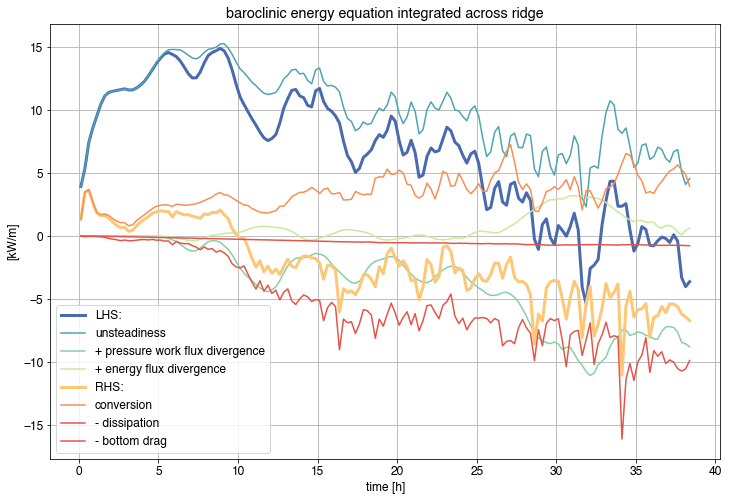

In [81]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(12,8))

cmaps = mpl.cm.get_cmap('Spectral')
b1 = cmaps(0.95)
b2 = cmaps(0.85)
b3 = cmaps(0.75)
b4 = cmaps(0.65)
r1 = cmaps(0.35)
r2 = cmaps(0.25)
r3 = cmaps(0.15)
r4 = cmaps(0.05)

ax.plot(time,BC_EnergyEquationLeft/1e3,color=b1,label='LHS:',linewidth=3)
ax.plot(time,BC_Unsteadiness/1e3,color=b2,label='unsteadiness')
ax.plot(time,(BCPressureFluxDepthIntegralDelta+nhBCPressureFluxDepthIntegralDelta)/1e3,color=b3,label='+ pressure work flux divergence')
ax.plot(time,BC_EnergyFluxDivergence/1e3,color=b4,label='+ energy flux divergence')

ax.plot(time,BC_EnergyEquationRight/1e3,color=r1,label='RHS:',linewidth=3)
ax.plot(time,BC_Conversion/1e3,color=r2,label='conversion')
ax.plot(time,-epsVI/1e3,color=r3,label='- dissipation')
ax.plot(time,-BottomDragVI/1e3,color=r3,label='- bottom drag')

ax.legend()
ax.grid()
ax.set(ylabel='[kW/m]',xlabel='time [h]',title='baroclinic energy equation integrated across ridge');

## Total Energy equation (work in progress)

The depth-integrated total energy equation describes the sum of time derivative and fluxes and equals this to dissipation and drag. Units are W/m$^2$.

### Advective Flux Divergence
$$\nabla_H \cdot (\overline{\mathbf{u}_H E_k} + \overline{\mathbf{u}_H E'_p})$$

In [ ]:
EkFlux = VC*Ek
# note: np.gradient second argument is distance if scalar but coordinates if vector.
DivEkFlux = np.gradient(np.nansum(EkFlux*drFC,axis=1),grid.Y,axis=1)
EppFlux = VC*Epp
DivEppFlux = np.gradient(np.nansum(EppFlux*drFC,axis=1),grid.Y,axis=1)
DivAdvFlux = np.gradient(np.nansum(EppFlux*drFC,axis=1)+np.nansum(EkFlux*drFC,axis=1),grid.Y,axis=1)

Plot time evolution of advective flux divergences.

In [ ]:
fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(12,5))
h = ax[0].contourf(dist,time,DivEkFlux,np.linspace(-100,100,41),cmap='RdBu_r')
plt.colorbar(h,ax=ax[0])
CenterPlot(25,ax[0])
h = ax[1].contourf(dist,time,DivEppFlux,np.linspace(-100,100,41),cmap='RdBu_r')
plt.colorbar(h,ax=ax[1])
CenterPlot(25,ax[1])
h = ax[2].contourf(dist,time,DivAdvFlux,np.linspace(-100,100,41),cmap='RdBu_r')
plt.colorbar(h,ax=ax[2])
CenterPlot(25,ax[2])

### Pressure Flux Divergence
$$\nabla_H \cdot ( \mathbf{U}_H H \rho_0 g \eta +   \overline{\mathbf{u}_H p'} + \overline{\mathbf{u}_H q})$$

The term related to the free surface anomaly becomes really big. It won't show up in the baroclinic energy equations anymore though, so shouldn't bother us too much.

In [ ]:
DivBaroPressureFlux = np.gradient(V*H*rho0*gravity*eta,grid.Y,axis=1)
DivPressureFlux = np.gradient(np.nansum(VC*PP*drFC,axis=1)+eta*VC[:,0,:]*PP[:,0,:],grid.Y,axis=1)
DivnhPressureFlux = np.gradient(np.nansum(VC*q*drFC,axis=1)+eta*VC[:,0,:]*q[:,0,:],grid.Y,axis=1)

In [ ]:
# plt.plot(dist,DivBaroPressureFlux[-1,:])
plt.plot(dist,DivPressureFlux[-100,:])
plt.plot(dist,DivnhPressureFlux[-100,:]);
CenterPlot(50)

In [ ]:
plt.plot(dist,eta[-10,:])
CenterPlot(50)

In [ ]:
plt.pcolormesh(dist,time,eta,cmap='RdBu_r',vmin=-0.2,vmax=0.2)
CenterPlot(20)


In [ ]:
plt.pcolormesh(V)
plt.colorbar

### Diffusive Flux Divergence
$$ - \overline{ \nabla_H \cdot (\nu_H \nabla_H E_k) }  -  \overline{ \nabla_H \cdot (\kappa_H g \zeta \nabla_H \rho') } $$
with the horizontal eddy viscosity (`viscAh`) $\nu_H$ [m$^2$/s] and horizontal diffusivity of heat (and thereby mass for the linear equation of state, `diffKhT`) $\kappa_H$. 

In [ ]:
DivDiffEk = -np.nansum(np.gradient((nuh*np.gradient(Ek,grid.Y,axis=2)),grid.Y,axis=2)*drFC,axis=1)
# DivDiffEp = 

In [ ]:
plt.contourf(dist,time,DivDiffEk,np.linspace(-5e-4,5e-4,31),cmap='RdBu_r')
plt.colorbar()
CenterPlot(25)

Diffusion is tiny compared to other terms. This may be right though, in [Kang and Fringer (2012)](http://journals.ametsoc.org/doi/abs/10.1175/JPO-D-11-039.1), diffusion contributes only 0.002% to the baroclinic energy flux divergence within a subdomain of their model.